# Week 9 - Graph Embeddings


This week, we are going to work with graph embeddings. Let's first import the needed libraries:

In [1]:
import networkx as nx
import scipy as sp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Below, we have included some code to plot the karate graph.

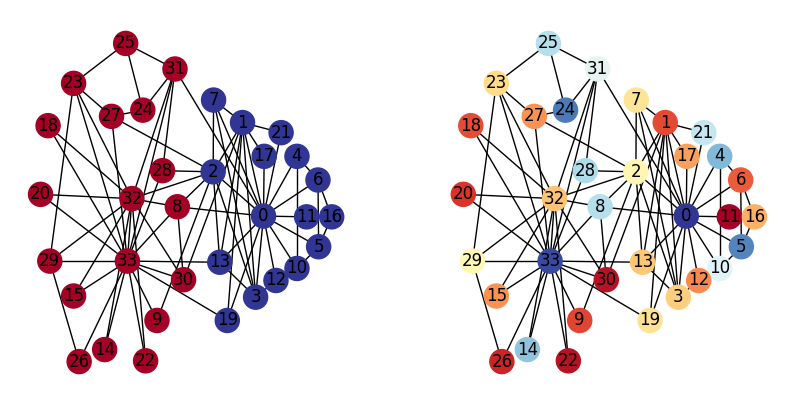

In [2]:
def plot_karate(G, pr=[], ax=None, cmap=plt.get_cmap('RdYlBu')): 
    fixed_positions = {0:(10.74,4.07),1:(9.76,6.48),2:(8.39,5.21),3:(10.37,1.98),4:(12.30,5.61),5:(13.31,3.28),6:(13.28,5.00),7:(8.41,7.06),8:(6.72,4.31),9:(5.77,1.38),10:(12.30,2.72),11:(12.75,4.05),12:(11.32,2.41),13:(8.70,2.88),14:(3.33,0.63),15:(1.88,2.01),16:(13.92,4.05),17:(10.77,5.61),18:(0.69,6.40),19:(9.05,1.38),20:(0.34,4.63),21:(11.56,6.22),22:(5.24,0.34),23:(1.88,7.49),24:(5.11,6.80),25:(4.31,8.52),26:(2.14,0.32),27:(3.65,6.64),28:(6.03,5.24),29:(0.77,2.91),30:(7.01,2.43),31:(6.61,7.86),32:(4.60,4.52),33:(4.39,2.91)}
    if len(pr) :
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax, cmap=cmap, node_color=pr)
    else : 
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax)

G = nx.karate_club_graph()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
magic_cut = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_karate(G, magic_cut, ax=ax[0])
plot_karate(G, np.random.rand(G.order()), ax=ax[1])

## Exercise 1 - Theory 

We will first test ourselves on the theory of embeddings. Assume we have the (very simple) undirected line graph below. The graph is a line where node 1 is connected to node 2 and node 2 is connected to node 3. 

(1)-(2)-(3)

1. Assume you have embedded the above graph with a **Linear Embedding** using the Adjacency matrix of the graph as the similarity matrix. How do you expect the embeddings to be if the embedding dimension is $d = 1$? Motivate your answer. <br>
Node $1$ and $3$ have the same value, but $2$ is mapped to a larger value.
2. Compute the linear embedding with $d=1$, showing all the steps. _Hint:_ Remember how to optimize linear embeddings! <br>

3. What happens to the linear embeddings with $d\in\{1,2,3\}$ if we create a star graph, where node 3 is the central node and all the others are connected to node 3, and node 0 is connected with node 1? For simplicity assume that the graph has $5$ nodes. 

## Exercise 2 - Similarity matrices
In this exercise, we will implement different similarity matrices.

For the following three node-similarity measures, implement the corresponding methods below.
 1. Adjacency similarity.
 1. 2-hop similarity ($A^2$).
 1. Come up with your own measure of node similarity. You could, e.g., take neighbor-overlap into account. 
 

In [64]:
def adjacency_similarity(G: nx.Graph):
    """
        Input: A networkx graph with n nodes
        Output: A normlized adjacency matrix of size [n, n], where each row sum to 1
    """
    ### YOUR CODE HERE    
    adj = nx.to_numpy_array(G)
    sum = np.sum(adj, axis=1)
    adj_norm = adj / sum[:, np.newaxis]
    return adj_norm
    ### YOUR CODE HERE   


def two_hub(G: nx.Graph, k=2):
    """
        Input: A networkx graph with n nodes
        Output: A^2, where A is the adjacency matrix 
    """
    ### YOUR CODE HERE    
    adj_hop = nx.to_numpy_array(G)
    adj_hop_k = np.linalg.matrix_power(adj_hop, k)
    adj_hop_k = adj_hop_k - np.diag(adj_hop_k)
    sum = np.sum(adj_hop, axis=1)
    adj_norm = adj_hop / sum[:, np.newaxis]
    return adj_norm
    ### YOUR CODE HERE    


def my_similarity(G: nx.Graph):
    """
        Input: A networkx graph with n nodes
        Output: A [n, n] matrix of pair-wise similarities
    """
    ### YOUR CODE HERE    
    n = G.number_of_nodes()
    matri = np.empty((n,n))
    for i in G.nodes():
        neigh_i = list(G.neighbors(i))
        for j in G.nodes():
            neigh_j = list(G.neighbors(j))
            inter = np.intersect1d(neigh_i,neigh_j)
            matri[i,j] = len(inter)
    
    matri = matri - np.diag(matri)
    sum = np.sum(matri, axis=1)
    adj_norm = matri / sum[:, np.newaxis]

    return adj_norm
    ### YOUR CODE HERE    

# # Check for normalization
fns = [adjacency_similarity,  two_hub, my_similarity]
fns = [adjacency_similarity,  my_similarity]
for fn in fns: 
    assert np.allclose(fn(G)[0].sum(), 1)
    assert fn(G).sum() == G.order()

Plotting similarities for Node 2


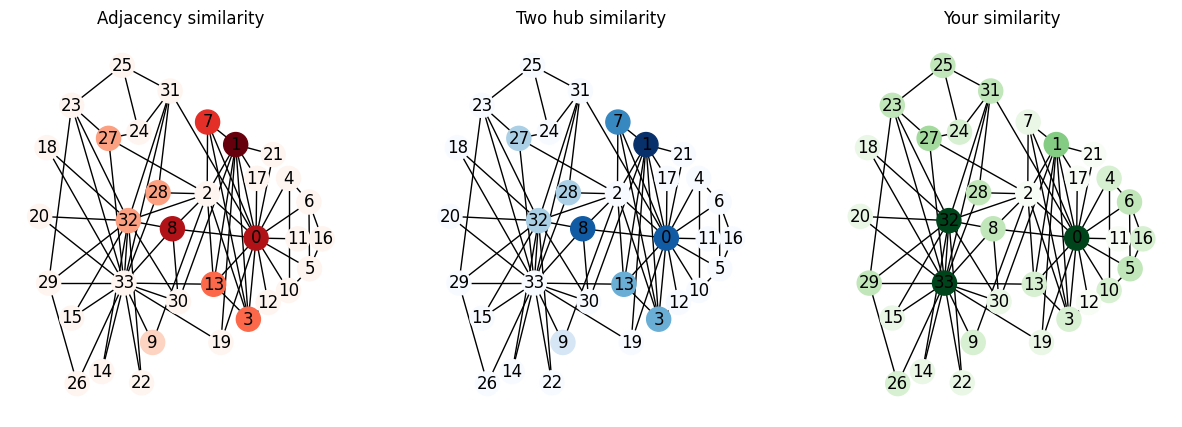

In [65]:
S1 = adjacency_similarity(G)
S2 = two_hub(G)
S3 = my_similarity(G)

# Plot similaritites
i = 2
print("Plotting similarities for Node %d" % i)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title("Adjacency similarity")
plot_karate(G, S1[i,:], ax=ax[0], cmap=plt.get_cmap('Reds'))
ax[1].set_title("Two hub similarity")
plot_karate(G, S2[i,:], ax=ax[1], cmap=plt.get_cmap('Blues'))
ax[2].set_title("Your similarity")
plot_karate(G, S3[i,:], ax=ax[2], cmap=plt.get_cmap('Greens'))

## Exercise 3 - Linear embeddings

This exercise is about Linear embeddings and how to perform dimensionality reduction on the similarity matrices above.

Linear embeddings typically perform some linear dimensionality reduction on, variations of the Adjacency matrix $A\in \{0,1\}^{n \times n}$ for an **undirected graph** $G = (V,E)$. 

A linear embedding finds a matrix $Z \in \mathbb{R}^{n\times d}$ which contains a $d$-dimensional representation of a given node in the network. The methods minimize a "reconstruction error" of the embedding with respect to the adjacecy matrix

$$
\mathcal{L}(A,Z) = \sum_{(i,j) \in E}(Z_{i}^\top Z_{j} - A_{i,j})^2 = \|ZZ^\top - A\|_F^2
$$

1. Show that if instead of one matrxix Z we have two $B \in \mathbb{R}^{n\times d}$ and $C \in \mathbb{R}^{n\times d}$, the best solution to the above minimization can be obtained by SVD on $A$
2. What is the gradient matrix of the above function for a single row $Z_{i\cdot}$ of the matrix $Z$?
3. Implement the linear embedding above using gradient descent on the three different similaririty matrices from Exercise 2.


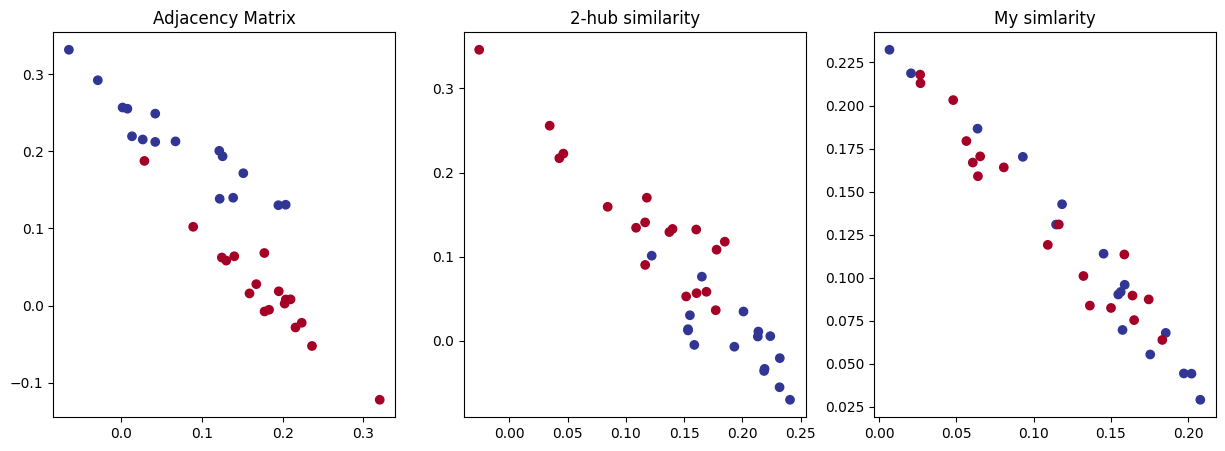

In [96]:
np.random.seed(0)

def lin_grads(A, Z): 
    ### YOUR CODE HERE
    return 2 * (Z @ Z.T - A) @ Z
    ### YOUR CODE HERE    

def lin_loss(A, Z): 
    ### YOUR CODE HERE
    pass
    ### YOUR CODE HERE
    
def learn(A, dim, grad = lin_grads, loss = lin_loss, step_size=0.001, steps=1000):
    n, _ = A.shape
    Z = np.random.rand(n, dim)
    
    ### YOUR CODE HERE 
    for i in range(steps):
        gradient = grad(A, Z)
        Z -= step_size * gradient

    ### END CODE
    return Z

# Project the graph in 2D and plot it as points in the space
Z1 = learn(S1, 2)
Z2 = learn(S2, 2)
Z3 = learn(S3, 2)

# As colors to see what happens we can use the communities 
# that have been found with the "magic method" in the beginning.
# A good embedding method should be able to separate the two colors! 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (Z, T) in enumerate(zip([Z1, Z2, Z3], ["Adjacency Matrix", "2-hub similarity", "My simlarity"])): 
    ax[i].set_title(T)
    ax[i].scatter(*(Z.T), c=magic_cut, cmap=plt.get_cmap('RdYlBu'))

## Exercise 4 - VERSE

In this exercise, we will try to implement and run one network embedding introduced in the lecture, called [VERSE](https://arxiv.org/pdf/1803.04742.pdf).

VERSE is a simple *autoencoder* which takes in input a graph $G=(V,E)$, a row-normalized similarity matrix $S$ and learns an embedding matrix $Z \in \mathbb{R}^{n\times d}$ using the following cross-entropy loss between the rows in $S$ and the rows in $ZZ^\top$.

VERSE loss function for each node $i$ is 
$$
\mathcal{L}(S_i,Z) = -S_i \log(\text{softmax}(Z_iZ^\top)) 
$$
$$
\log(\text{softmax}(Z_iZ^\top))  = [\log\frac{e^{Z_iZ_0^\top}}{\sum_je^{Z_iZ_j^\top}},\log\frac{e^{Z_iZ_1^\top}}{\sum_je^{Z_iZ_j^\top}},...,\log\frac{e^{Z_iZ_{n-1}^\top}}{\sum_je^{Z_iZ_j^\top}}]
$$
$$
-S_i\log(\text{softmax}(Z_iZ^\top))   = -({S_i}_0\log\frac{e^{Z_iZ_0^\top}}{\sum_je^{Z_iZ_j^\top}}+{S_i}_1\log\frac{e^{Z_iZ_1^\top}}{\sum_je^{Z_iZ_j^\top}}+...+{S_i}_{n-1}\log\frac{e^{Z_iZ_{n-1}^\top}}{\sum_je^{Z_iZ_j^\top}})
$$

which can be written in terms of the global loss
$$
\mathcal{L}(S,Z) = \sum_{i \in V}\mathcal{L}(S_i,Z)
$$
here $\text{softmax}(\cdot)$ is the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function. 

The similarity matrix in case of VERSE is typically the Personalized PageRank (PPR) matrix. For the scope of the exercise we will use the the PageRank algorithm with $\alpha = 0.85$.



We will implement the full VERSE method and understand how it works in practice 
1. Compute the PageRank algorithm with $\alpha = 0.85$. 
2. Implement the VERSE Loss function
3. Compute the gradient of the loss function. **Hint: do it row-wise (i.e., node-by-node)**
4. Try to change the parameters and use another similarity function. What other similarity function among nodes can you use? 

In [99]:
from scipy.special import softmax

def pagerank_matrix(G, alpha = 0.85) :     
    ### YOUR CODE HERE
    P = np.empty((G.number_of_nodes(), G.number_of_nodes()), dtype=float)
    for i in G.nodes():
        page_rank = nx.pagerank(G, alpha=alpha, personalization = {i: 1})
        P[i] = list(page_rank.values())
    return P
    ### YOUR CODE HERE

G = nx.karate_club_graph()
P = pagerank_matrix(G)

# Sanity checks on the matrix
n = G.number_of_nodes()
per = np.zeros(n)
per[2] = 1

# assert np.allclose(my_pagerank(G,r=per), P[2,:], atol=1e-3, rtol=1e-3), "%s\n%s" % (str(my_pagerank(G, r=per)), str(P[2]))
# assert np.allclose(P[1,:].sum(), 1.)
# End sanity check.

print(pagerank_matrix(G))
print(nx.pagerank(G, personalization={i: 1 if i == 0 else 0 for i in range(n)}))


[[0.25868149 0.07618885 0.07488591 ... 0.02486537 0.03210613 0.04481188]
 [0.11033728 0.23114702 0.09651285 ... 0.01967348 0.03748146 0.05331786]
 [0.09530158 0.0848114  0.22410525 ... 0.02595125 0.05325176 0.06684676]
 ...
 [0.04973262 0.02716577 0.04077536 ... 0.21798996 0.09450773 0.11312704]
 [0.03548769 0.02860168 0.04623972 ... 0.05222799 0.250915   0.12794374]
 [0.03921226 0.03221061 0.04595255 ... 0.04949307 0.10128871 0.26426893]]
{0: 0.2586814904840389, 1: 0.07618884833001639, 2: 0.07488591193830409, 3: 0.048920593377997826, 4: 0.03050072647529325, 5: 0.04621087522084753, 6: 0.043409925083705274, 7: 0.03404846944645621, 8: 0.028522268799148143, 9: 0.003516039991625176, 10: 0.028608810402927558, 11: 0.015705506760724006, 12: 0.012165474883403053, 13: 0.041968624699790465, 14: 0.003741810281140182, 15: 0.005328984539894554, 16: 0.016931346556320285, 17: 0.012703428518314824, 18: 0.0023053862662163085, 19: 0.01573010632552416, 20: 0.002948223151762995, 21: 0.014936519196146974, 

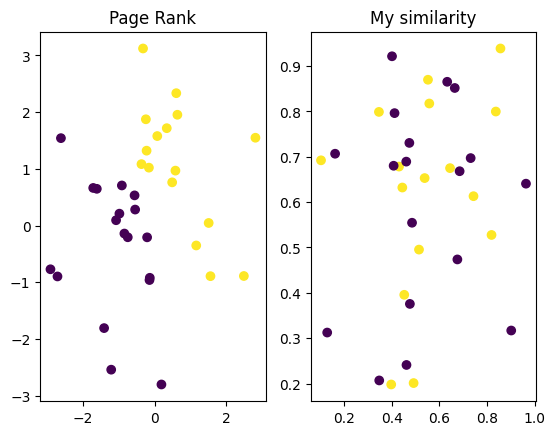

In [114]:
def verse_loss(S, Z): 
    from scipy.special import softmax
    loss = 0
    ### YOUR CODE HERE
    n, d = Z.shape
    for i in range(n):
        loss += np.dot(S[i,:], np.log(softmax(Z[i,:] @ Z)))
    ### YOUR CODE HERE
    return loss

def verse_grads(S, Z): 
    grads = np.zeros(Z.shape)
    ### YOUR CODE HERE 
    # TODO: Perhaps this is not all correct
    scores = softmax(Z @ Z.T, axis = 1)
    grads = (np.dot(scores, S) - S) @ Z
    ### YOUR CODE HERE 
    return grads

Z1 = learn(P, 2, grad=verse_grads, loss=verse_loss, step_size = 0.005, steps=4000)
Z2 = learn(S3, 2, grad=verse_grads, loss=verse_loss, step_size = 0.005, steps=4000)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(np.array(Z1[:,0]), np.array(Z1[:,1]), c=magic_cut)
ax[0].set_title("Page Rank")
ax[1].scatter(np.array(Z2[:,0]), np.array(Z2[:,1]), c=magic_cut)
ax[1].set_title("My similarity")
plt.show()